In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.6'

# Visualizing heatmaps of class activation

It is useful for understanding whihc parts of a given image led a convnet to its final classification decision.

This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the image are.

In [2]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 5s 0us/step


Let's consider the following image of two African elephants, possible a mother and its cub, strolling in the savanna.


![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

Let's convert this image into something the VGG16 model can read: the model was trained on images of size 244x244, preprocessed according to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize it to 244x244, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = 'creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [11]:
preds = model.predict(x)
print('Predicted: ', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 1us/step
Predicted:  [('n02504458', 'African_elephant', 0.9094207), ('n01871265', 'tusker', 0.08618318), ('n02504013', 'Indian_elephant', 0.0043545896)]


Our network has recognized our image as containing an indetermined quality of African elephants. The entry in the prediction vector that was maximally activated is the one corresponding to the "African elephant" class, at index 386:

In [12]:
np.argmax(preds[0])

386

In [0]:
# Set up Grad-CAM process
from keras import backend as K


# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)


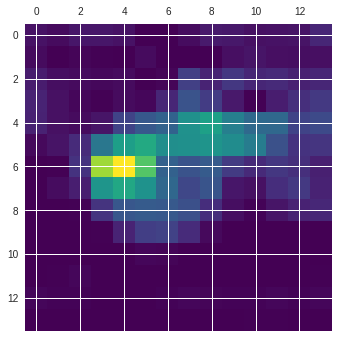

In [17]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap, cmap='viridis')
plt.show()

In [19]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

![elephant cam](https://s3.amazonaws.com/book.keras.io/img/ch5/elephant_cam.jpg)

This visualisation technique answers two important questions:

  *  Why did the network think this image contained an African elephant?
 *   Where is the African elephant located in the picture?

In particular, it is interesting to note that the ears of the elephant cub are strongly activated: this is probably how the network can tell the difference between African and Indian elephants.
